In [55]:
import qiskit
from qiskit.tools.visualization import plot_histogram
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn 
from collections import namedtuple, deque
import random
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import clear_output
import time
%matplotlib inline

# Qiskit Environment Wrapper

In [60]:
class QuantumCircuitEnvironment():
    
    def __init__(self, n_qbits, goal_state, max_t, graphics=False):
        self.n_qbits = n_qbits
        self.goal_state = goal_state # Used to calculate reward on each environment step
        assert(len(goal_state) == (2 ** self.n_qbits)), "goal_state must match the outcomes possible with n_qbits"
        self.graphics = graphics
        """
        self.n_shots needs to be an arbirarily large number otherwise the variance in intermediate and final
        states will be so large that the model will never converge.  Also it would cause some episodes to never 
        end due to the terminal criteria of the environment.
        """
        self.max_t = max_t
        self.t = 0
        self.n_shots = 100000 
        self.sim = qiskit.Aer.get_backend('qasm_simulator')
        self.qc = qiskit.QuantumCircuit(self.n_qbits, self.n_qbits)
        self.actions = {0:(lambda:self.qc.h(0)),1:(lambda:self.qc.h(1)),2:(lambda:self.qc.h(2)), 
                        3:(lambda:self.qc.x(0)),4:(lambda:self.qc.x(1)),5:(lambda:self.qc.x(2)), 
                        6:(lambda:self.qc.cx(0,1)),7:(lambda:self.qc.cx(0,2)),8:(lambda:self.qc.cx(1,2)),
                        9:(lambda:self.qc.cx(1,0)),10:(lambda:self.qc.cx(2,0)),11:(lambda:self.qc.cx(2,1))}

    def step(self, action):
        self.t += 1
        # Delete the 3 measurements of the previous env step, not possible with an actual quantum register.
        self.qc.data = self.qc.data[:-3] 
        self.actions[action]()
        if self.graphics:
            display(self.qc.draw(output='mpl'))
        self.qc.measure([i for i in range(self.n_qbits)], [i for i in range(self.n_qbits)])
        counts = qiskit.execute(self.qc, backend=self.sim, shots=self.n_shots).result().get_counts()     
        max_diff = 0
        next_state = []
        for key in list(goal_state.keys()):
            next_state.append(counts.get(key, 0) / self.n_shots)
            diff = abs(next_state[-1] - goal_state[key])
            if diff > max_diff:
                max_diff = diff
        done = True if max_diff < 0.02 or self.t == self.max_t else False
#         if done and self.graphics:
#             display(plot_histogram(counts))  
        reward = -1 if not done else 0
        next_state = np.array(next_state)
        return next_state, reward, done
    
    def reset(self):
        self.qc.data = []
        if self.graphics:
            display(self.qc.draw(output='mpl'))
        self.t = 0
        # Qiskit always starts all qbits in 0 state, so starting state is 100% all qbits '000'
        start_state = np.array([1.0, 0, 0, 0, 0, 0, 0, 0])
        return start_state

# DQN Architecture

In [34]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self, device):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [35]:
class ActionValueNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(ActionValueNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def save_checkpoint(self, filename):
        torch.save(self.state_dict(), filename)
    
    def load_checkpoint(self, filename):
        self.load_state_dict(torch.load(filename))

In [36]:
class DQNAgent():

    def __init__(self, state_size, action_size, seed=1, buffer_size=10000,
                 batch_size=128, gamma=0.99, tau=.001, alpha=.001, update_every=4):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.update_every = update_every
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # Q-Network
        self.qnetwork_local = ActionValueNetwork(state_size, action_size, seed).to(self.device)
        self.qnetwork_target = ActionValueNetwork(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=alpha)
        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample(self.device)
            self.learn(experiences)

    def act(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # Update target networks if necessary
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save_model(self, filename):
        self.qnetwork_local.save_checkpoint(filename)
    
    def load_model(self, filename):
        self.qnetwork_local.load_checkpoint(filename)

# Hyperparameters and Goal State Specification

In [37]:
# Goal State Specification
n_qbits = 3
goal_state = {'000' : 0, '001' : 0.25, '010' : 0.25, '011' : 0, '100' : 0, '101' : 0.25, '110' : 0.25, '111' : 0}
max_t = 10 # Max timesteps per episode

# Watch Trained Agent Create to meet goal

Action: 6
Next State:


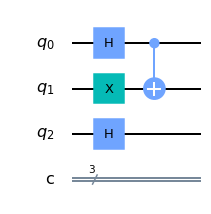

Goal State Reached!
Score: -3


In [83]:
env = QuantumCircuitEnvironment(n_qbits, goal_state, max_t, graphics=True)
action_size = len(env.actions)
state_size = len(env.goal_state)
agent = DQNAgent(state_size, action_size)
agent.load_model('best_model.pt')
for episode in range(testing_episodes):
    clear_output(wait = True)
    print('Goal State:', list(goal_state.values()))
    print('Start State:')
    s = env.reset()
    time.sleep(15)
    score = 0
    d = False
    while not d:
        a = agent.act(s, 0)
        clear_output(wait=True)
        print('Action:', a)
        print('Next State:')
        s_, r, d = env.step(a)
        time.sleep(3)
        score += r
        s = s_
    print('Goal State Reached!')
    print('Score:', score)